# Water Risk Classification: Data Wrangling

## Setup

In [45]:
import pandas as pd
import geopandas as gpd
import requests, zipfile, io, os, tarfile
from matplotlib import pyplot

import rasterio as rio
from rasterio import plot
from rasterio.warp import calculate_default_transform, reproject, Resampling
import rioxarray # for the extension to load
import xarray

%matplotlib inline


## Download Data
**ONLY RUN IF YOU DON'T HAVE THE DATA FOLDER YET. IT WILL TAKE A LONG TIME.**

Download and unzip all the datasets. 

In [2]:
# create data folder
os.mkdir('./data')

In [4]:
# download and extract
# DON'T RUN IF DATA IS IN ./DATA FOLDER
url_aq = 'https://wri-projects.s3.amazonaws.com/Aqueduct30/finalData/Y2019M07D12_Aqueduct30_V01.zip'

r = requests.get(url_aq) # download zipped directory
z = zipfile.ZipFile(io.BytesIO(r.content)) # create zipfile object
z.extractall(path='data') # unzip into data subdirectory

In [5]:
# download and extract
# DON'T RUN IF DATA IS IN ./DATA FOLDER
url_ghs = 'http://cidportal.jrc.ec.europa.eu/ftp/jrc-opendata/GHSL/GHS_SMOD_POP_GLOBE_R2019A/GHS_SMOD_POP2015_GLOBE_R2019A_54009_1K/V1-0/GHS_SMOD_POP2015_GLOBE_R2019A_54009_1K_V1_0.zip'

r = requests.get(url_ghs) # download zipped directory
z = zipfile.ZipFile(io.BytesIO(r.content)) # create zipfile object
z.extractall(path='data/ghs') # unzip into data subdirectory

In [10]:
# This download requires useer authentication and isn't currently working
# DON'T RUN IF DATA IS IN ./DATA FOLDER
url_inf_mort = 'https://sedac.ciesin.columbia.edu/downloads/data/povmap/povmap-global-subnational-infant-mortality-rates-v2/povmap-global-subnational-infant-mortality-rates-v2-geotiff.zip'

r = requests.get(url_inf_mort) # download zipped directory
z = zipfile.ZipFile("./data/povmap-global-subnational-infant-mortality-rates-v2-geotiff.zip") # create zipfile object
z.extractall(path='data/sedac') # unzip into data subdirectory
z.close()

In [34]:
# download and extract
# DON'T RUN IF DATA IS IN ./DATA FOLDER
url_light = 'https://ngdc.noaa.gov/eog/data/web_data/v4avg_lights_x_pct/F182013.v4c.avg_lights_x_pct.tgz'

r = requests.get(url_light, allow_redirects=True)
open('./data/F182013.v4c.avg_lights_x_pct.tgz', 'wb').write(r.content)

KeyboardInterrupt: 

In [38]:
temp_path = './data/F182013.v4c.avg_lights_x_pct.tgz'

z = tarfile.open(temp_path, mode='r:gz') # create zipfile object
z.extractall(path='data/light') # unzip into data subdirectory
z.close()

os.remove(temp_path)

## Load Data

WRI Aqueduct metadata with column name explanations is available [here](https://github.com/wri/aqueduct30_data_download/blob/master/metadata.md).

In [3]:
path_aq = './data/Y2019M07D12_Aqueduct30_V01/baseline/annual/y2019m07d11_aqueduct30_annual_v01.gpkg'

aq = gpd.read_file(path_aq, layer='y2019m07d11_aqueduct30_annual_v01')

aq.head()

,string_id,aq30_id,pfaf_id,gid_1,aqid,gid_0,name_0,name_1,area_km2,bws_raw,...,w_awr_tex_rrr_score,w_awr_tex_rrr_cat,w_awr_tex_rrr_label,w_awr_tex_rrr_weight_fraction,w_awr_tex_tot_raw,w_awr_tex_tot_score,w_awr_tex_tot_cat,w_awr_tex_tot_label,w_awr_tex_tot_weight_fraction,geometry
0,111011-EGY.11_1-3365,0,111011,EGY.11_1,3365,EGY,Egypt,Al Qahirah,4.223754,2.318042,...,2.165272,2.0,Medium - High (2-3),0.326531,2.457171,3.614603,3.0,High (3-4),0.877551,(POLYGON ((31.90590570688292 29.85788703615783...
1,111011-EGY.15_1-3365,1,111011,EGY.15_1,3365,EGY,Egypt,As Suways,1846.012343,2.318042,...,2.165272,2.0,Medium - High (2-3),0.326531,2.457171,3.614603,3.0,High (3-4),0.877551,(POLYGON ((31.90256665452753 29.82957728496378...
2,111011-EGY.15_1-None,2,111011,EGY.15_1,-9999,EGY,Egypt,As Suways,30.526067,2.318042,...,2.165272,2.0,Medium - High (2-3),0.326531,2.457171,3.614603,3.0,High (3-4),0.877551,(POLYGON ((32.36609158210641 29.63378296420298...
3,111011-None-3365,3,111011,-9999,3365,None,None,None,0.742712,2.318042,...,1.133763,1.0,Low - Medium (1-2),0.163265,2.477321,3.649648,3.0,High (3-4),0.551020,(POLYGON ((32.46194054146073 29.89250514754305...
4,111011-None-None,4,111011,-9999,-9999,None,None,None,13.430995,2.318042,...,1.133763,1.0,Low - Medium (1-2),0.163265,2.477321,3.649648,3.0,High (3-4),0.551020,(POLYGON ((32.46439791820441 29.88855938783929...


In [47]:
path_ghs = './data/ghs/GHS_SMOD_POP2015_GLOBE_R2019A_54009_1K_V1_0.tif'

ghs = rio.open(path_ghs)

In [12]:
path_inf_mort = './data/sedac/povmap_global_subnational_infant_mortality_rates_v2.tif'

inf_mort = rio.open(path_inf_mort)

In [13]:
# This codeblock doesn't run bc of error below
# RasterioIOError: This is a BigTIFF file.  BigTIFF is not supported by this version of GDAL and libtiff.
path_light1 = './data/light/F182013.v4c.avg_lights_x_pct.tif'
path_light2 = './data/light/F182013.v4c.pct_lights.tif'

light1 = rio.open(path_light1)
light2 = rio.open(path_light2)

## Explore Data

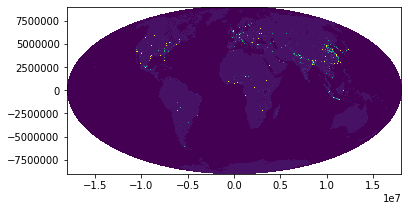

({'driver': 'GTiff',
  'dtype': 'int16',
  'nodata': -200.0,
  'width': 36082,
  'height': 18000,
  'count': 1,
  'crs': CRS.from_wkt('PROJCS["World_Mollweide",GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137.0,298.257223563]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.017453292519943295]],PROJECTION["Mollweide"],PARAMETER["False_Easting",0.0],PARAMETER["False_Northing",0.0],PARAMETER["Central_Meridian",0.0],UNIT["Meter",1.0]]'),
  'transform': Affine(1000.0, 0.0, -18041000.0,
         0.0, -1000.0, 9000000.0)},
 <matplotlib.axes._subplots.AxesSubplot at 0x1cd803c7988>)

In [50]:
ghs.meta,plot.show(ghs)

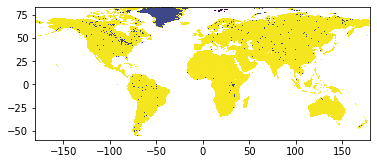

({'driver': 'GTiff',
  'dtype': 'float64',
  'nodata': -1.7976931348623157e+308,
  'width': 43200,
  'height': 17173,
  'count': 1,
  'crs': CRS.from_dict(init='epsg:4326'),
  'transform': Affine(0.00833333333333333, 0.0, -179.99999999999997,
         0.0, -0.00833333333333333, 83.62711161733333)},
 <matplotlib.axes._subplots.AxesSubplot at 0x1cd804ba2c8>)

In [51]:
inf_mort.meta,plot.show(inf_mort)

In [17]:
# check crs
aq.crs, aq.crs == ghs.crs, aq.crs == inf_mort.crs

({'init': 'epsg:4326'}, False, True)

In [42]:
# code from https://www.earthdatascience.org/courses/earth-analytics-python/lidar-raster-data/reproject-raster/
transform, width, height = calculate_default_transform(
        ghs.crs, aq.crs, ghs.width, ghs.height, *ghs.bounds)
metacopy = ghs.meta.copy()
metacopy.update({
        'crs': aq.crs,
        'transform': transform,
        'width': width,
        'height': height})

ghsr = reproject(source=ghs,
                 destination=ghs,
                 src_transform=ghs.transform,
                 src_crs=ghs.crs,
                 dst_transform=transform,
                 dst_crs=aq.crs,
                 resampling=Resampling.nearest)

ValueError: Invalid source

## Join Data

## Engineer Features

## Save GeoJSON for Modeling